# São Tomé

We will begin by loading all the required libraries and packages:

In [66]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from numpy.random import uniform
from sklearn.preprocessing import normalize
import MGSurvE as srv
import cartopy.crs as ccrs

## Landscape

We will now setup some of the experiment's constants. In this case we will setup the experiment to 7 traps (`TRPS`) by default with the option to set two traps as fixed (`FXD_TRPS`) as `True`. These fixed traps will be located in two small landmasses at the north and south of the main São Tomé landscape. The experiment id `ID` is just a label for the output files, with the run id `RID` being used for iterations of the stochastic optimization process; and the `IX_SPLIT` used to separate to separate sites in São Tomé from the ones in the island of Príncipe. Finally, we will create a folder to export our results.

In [67]:
(TRPS_NUM, FXD_TRPS) = (7, True)
# Experiment ID (RID) and stochastic iteration id (RID) -----------------------
(ID, RID) = ('STP', 0)
IX_SPLIT = 27
# Output folder ---------------------------------------------------------------
OUT_PTH = './sims_out/'
srv.makeFolder(OUT_PTH)

In [68]:
sites = pd.read_csv(path.join('./GEO', 'STP_LatLonN.csv'))
sites['t'] = [0]*sites.shape[0]
SAO_TOME_LL = sites.iloc[IX_SPLIT:]
SAO_bbox = (
    (min(SAO_TOME_LL['lon']), max(SAO_TOME_LL['lon'])),
    (min(SAO_TOME_LL['lat']), max(SAO_TOME_LL['lat']))
)
SAO_cntr = [i[0]+(i[1]-i[0])/2 for i in SAO_bbox]
SAO_LIMITS = ((6.41, 6.79), (-0.0475, .45))

In [69]:
SAO_FIXED = [51-IX_SPLIT, 239-IX_SPLIT]
FXD_NUM = len(SAO_FIXED)

In [70]:
migration = np.genfromtxt(
    path.join('./GEO', 'STP_MigrationN.csv'), delimiter=','
)
msplit = migration[IX_SPLIT:,IX_SPLIT:]
SAO_TOME_MIG = normalize(msplit, axis=1, norm='l1')

In [71]:
(initTyp, initFxd) = ([0]*TRPS_NUM, [0]*TRPS_NUM)
(initLon, initLat) = ([
    uniform(*SAO_bbox[0], TRPS_NUM), uniform(*SAO_bbox[1], TRPS_NUM)
])
if FXD_TRPS:
    initFxd = ([0]*(TRPS_NUM-FXD_NUM) + [1]*FXD_NUM)
sid = [0]*(TRPS_NUM-FXD_NUM) + SAO_FIXED 
traps = pd.DataFrame({
    'sid': sid,
    'lon': initLon, 'lat': initLat, 
    't': initTyp, 'f': initFxd
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

In [72]:
lnd = srv.Landscape(
    SAO_TOME_LL, migrationMatrix=SAO_TOME_MIG,
    traps=traps, trapsKernels=tKer, landLimits=SAO_LIMITS,
    trapsRadii=[1],
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

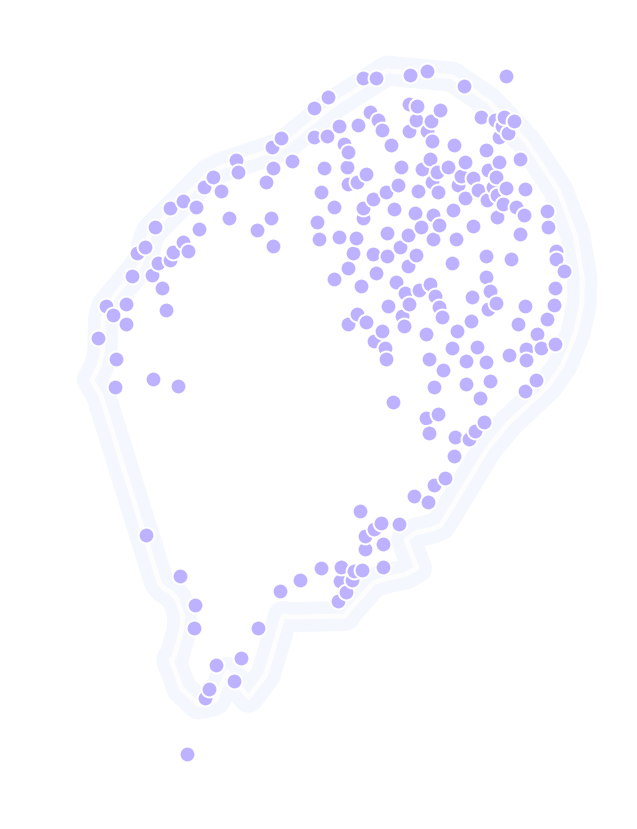

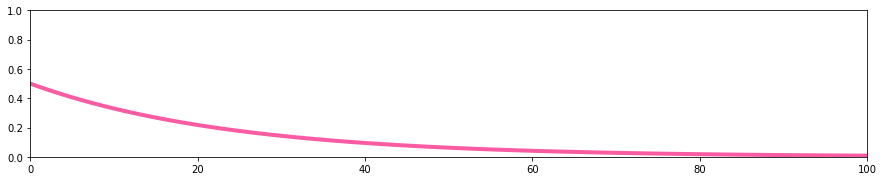

In [74]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=60, alphaMin=.1, alphaAmplitude=5,
# )
lnd.plotLandBoundary(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}_{:02d}_CLN.png'.format(ID, TRPS_NUM)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)
# Plot Traps Kernels ----------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
(fig, ax) = srv.plotTrapsKernels(fig, ax, lnd, distRange=(0, 100), aspect=.175)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_KER.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

## Optimization

In [75]:
(GENS, GA_SUMSTAT, VERBOSE) = (100, np.mean, False)
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
VERBOSE = True
# Reducing the bbox for init sampling -----------------------------------------
redFract = .25
reduction = [(i[1]-i[0])/2*redFract for i in bbox]
bboxRed = [(i[0]+r, i[1]-r) for (i, r) in zip(bbox,reduction)]

In [76]:
outer = GA_SUMSTAT
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': outer}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{}_{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{}_{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

/home/hector/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/hector/miniconda3/envs/MGSurvE/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    	max    	std    	best	traps                          
0  	105   	1772.02	2460.58	3860.51	385.245	24  	[29, 77, 208, 126, 83, 24, 212]
1  	53    	1772.02	2251.64	3970.34	341.125	48  	[29, 77, 208, 126, 83, 24, 212]
2  	65    	1772.02	2191.76	3771.03	338.494	48  	[29, 77, 208, 126, 83, 24, 212]
3  	59    	1734.2 	2131.98	3284.83	297.314	38  	[124, 78, 28, 220, 66, 24, 212]
4  	53    	1709.79	2042.98	3039.52	247.976	92  	[29, 77, 207, 59, 158, 24, 212]
5  	67    	1628.08	2060.96	4208.7 	389.835	22  	[29, 77, 208, 126, 131, 24, 212]
6  	61    	1628.08	2010.35	3945.48	343.143	29  	[29, 77, 208, 126, 131, 24, 212]
7  	54    	1628.08	2015.26	6380.28	546.111	42  	[29, 77, 208, 126, 131, 24, 212]
8  	62    	1593.76	1949.08	3200.74	303.416	13  	[29, 77, 208, 119, 131, 24, 212]
9  	65    	1593.76	1945.91	3006.84	318.176	74  	[29, 77, 208, 119, 131, 24, 212]
10 	66    	1593.76	1910.27	3818.07	336.278	30  	[29, 77, 208, 119, 131, 24, 212]
11 	67    	1593.76	1927.57	4743.37

## Analysis

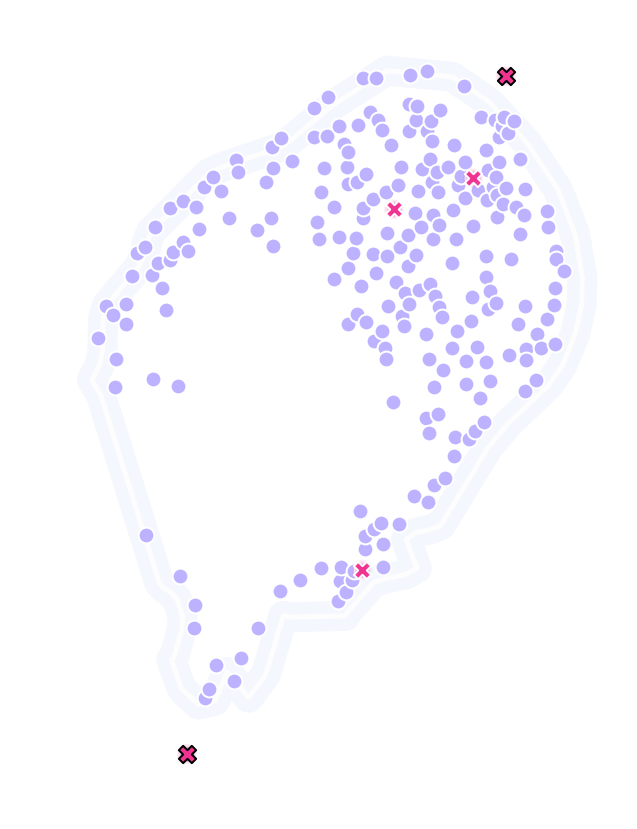

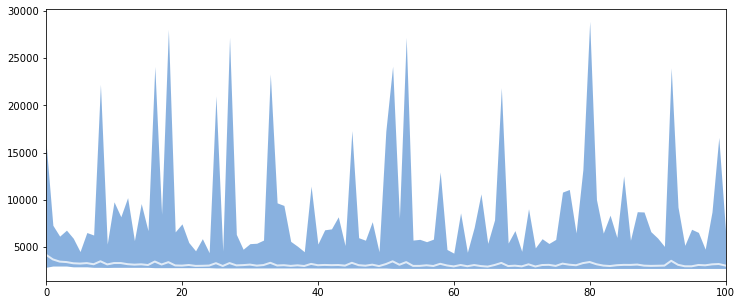

In [ ]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=250)
# lnd.plotMigrationNetwork(
#     fig, ax, lineWidth=30, alphaMin=.25, alphaAmplitude=2.5
# )
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    latlon=True, proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
# srv.plotFitness(fig, ax, min(dta['min']), fmt='{:.2f}')
lnd.plotLandBoundary(fig, ax)
# srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)
# GA --------------------------------------------------------------------------
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=1/2.5
)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)